# **Phase 2**
**Asteroid Deflection Simulation using Satellite Impact**

# **Overview**

This project simulates an asteroid deflection scenario using a satellite impact. The model accounts for gravity, atmospheric drag, and solar radiation pressure to predict the asteroid’s post-impact trajectory using numpy, matplotlib, and scipy.

**Methodology**

Momentum Conservation: The satellite impact alters the asteroid's velocity using linear momentum conservation.

Forces Considered:

***Gravity:*** Attraction from a nearby planet.

***Atmospheric Drag:*** Resistance if the asteroid enters the atmosphere.

***Solar Radiation:*** Small but persistent force affecting long-term motion.

Numerical Integration: solve_ivp from scipy.integrate simulates the asteroid’s motion over 11.5 days.

**Results**

Trajectory Analysis: The asteroid’s motion is significantly altered by the impact and planetary gravity.

Velocity & Acceleration: Variations in speed and acceleration are plotted for analysis.

Altitude Changes: If the asteroid enters the atmosphere, drag slows it down.

Future Improvements

Include multi-body gravitational interactions.

Analyze different impact angles and speeds.

Utilize AI to optimize deflection strategies.

**Conclusion:**

The simulation highlights the potential of satellite impact as an asteroid deflection strategy, contributing to planetary defense efforts.

<ipython-input-3-66a44eb80b6c>:139: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


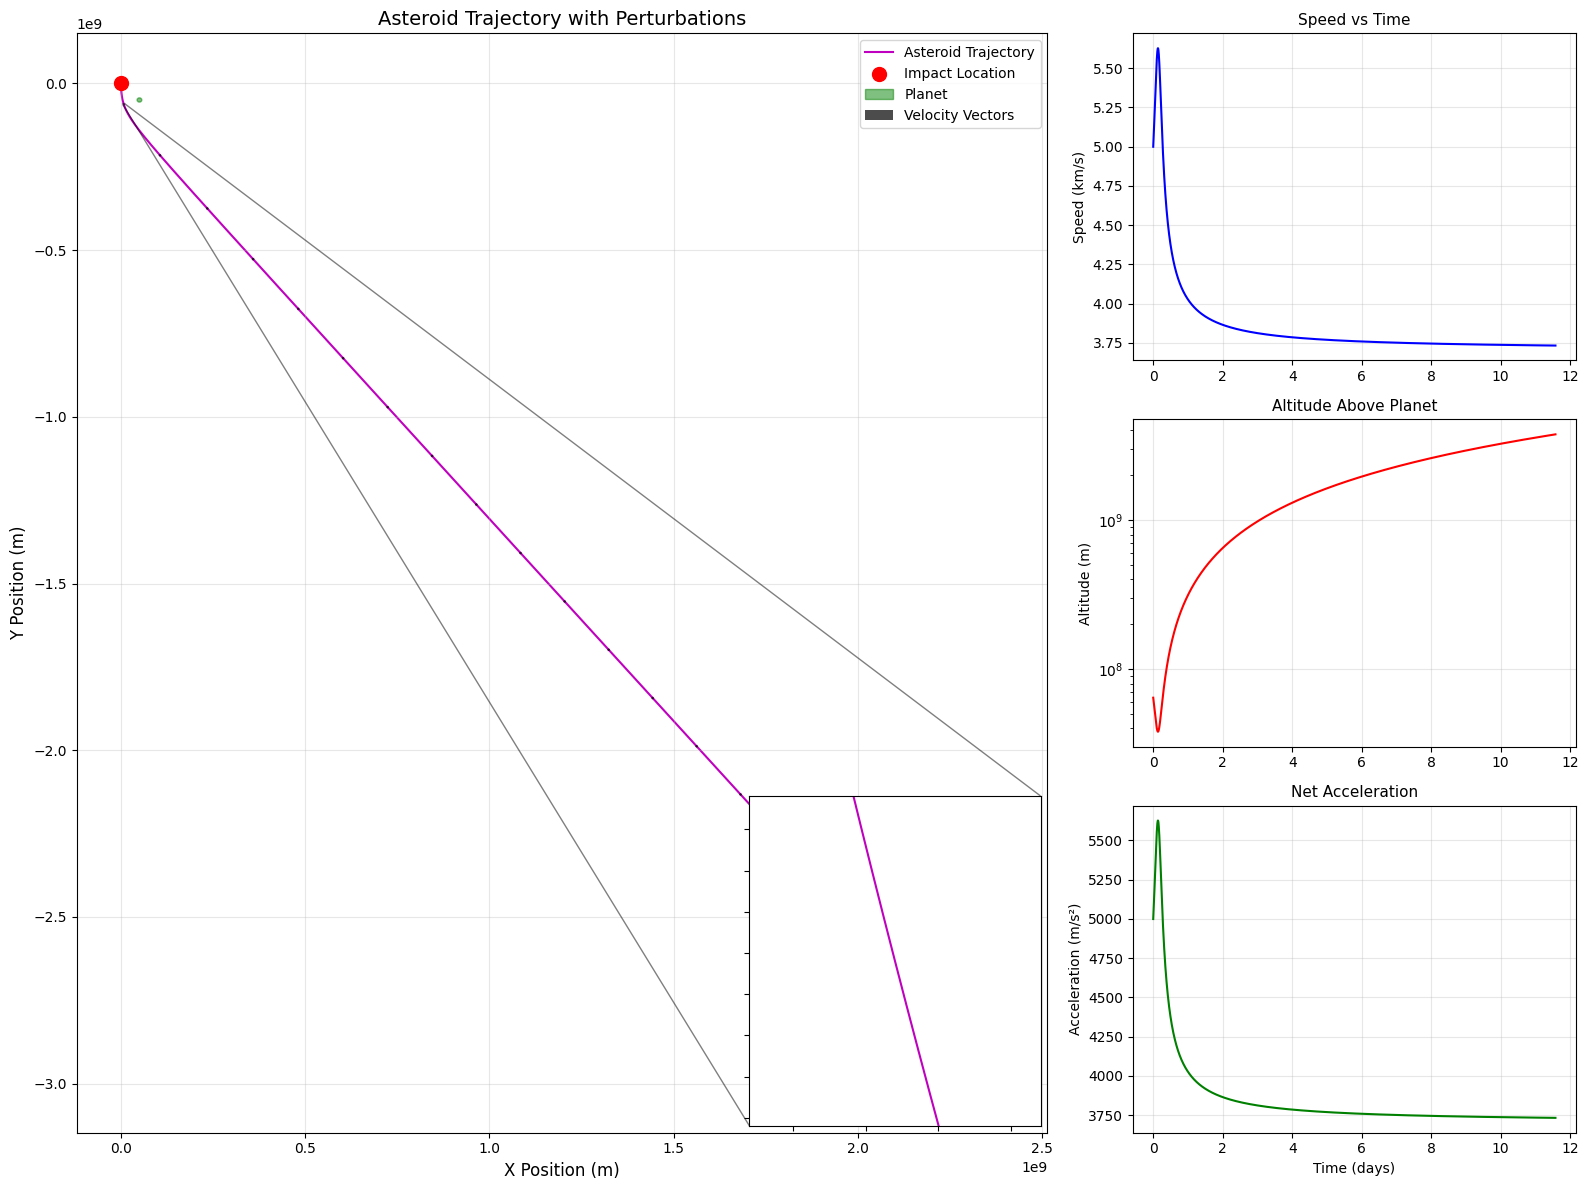

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from matplotlib.patches import Circle
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Define asteroid and satellite properties
asteroid_mass = 1e10
satellite_mass = 5e5
satellite_speed = 2e4
asteroid_velocity = np.array([0, -5000])
satellite_velocity = np.array([0, satellite_speed])

# Calculate post-impact velocity using momentum conservation
delta_v = (satellite_mass / (asteroid_mass + satellite_mass)) * satellite_velocity
initial_velocity = asteroid_velocity + delta_v

# Celestial body parameters
G = 6.67430e-11
planet_mass = 5.972e24
planet_radius = 6.371e6
planet_position = np.array([5e7, -5e7])

# Solar radiation parameters
solar_constant = 1361
speed_of_light = 3e8
cross_section = 500

# Atmospheric model parameters
surface_density = 1.225
scale_height = 8400
drag_coefficient = 1.2

def impact_effect(t, y):
    """Differential equations for asteroid motion with gravity, drag, and radiation pressure."""
    ax, ay, vx, vy = y

    # Gravitational acceleration from planet
    planet_vector = planet_position - np.array([ax, ay])
    distance = np.linalg.norm(planet_vector)
    gravity_dir = planet_vector / distance
    gravity_accel = G * planet_mass / distance**2 * gravity_dir

    # Atmospheric drag (only if within atmosphere)
    altitude = distance - planet_radius
    if altitude < 1e6:  # calculation krin upper atmosphere(ozone layer sa oper wali) ki
        air_density = surface_density * np.exp(-altitude/scale_height)
        relative_vel = np.array([vx, vy])
        speed = np.linalg.norm(relative_vel)
        if speed > 0:
            drag_accel = -0.5 * drag_coefficient * air_density * speed * relative_vel / asteroid_mass
        else:
            drag_accel = np.zeros(2)
    else:
        drag_accel = np.zeros(2)

    # Solar radiation pressure (Sun at [1e11, 1e11])
    sun_vector = np.array([1e11, 1e11]) - np.array([ax, ay])
    sun_distance = np.linalg.norm(sun_vector)
    radiation_pressure = solar_constant / speed_of_light
    radiation_accel = radiation_pressure * cross_section * sun_vector/(sun_distance*asteroid_mass)

    # Total acceleration components
    total_accel = gravity_accel + drag_accel + radiation_accel

    return [vx, vy, total_accel[0], total_accel[1]]

# Solve the system
time_span = (0, 1e6)  # simulate krin gy 11.5 days
t_eval = np.linspace(0, 1e6, 10000)
initial_conditions = [0, 0, initial_velocity[0], initial_velocity[1]]
sol = solve_ivp(impact_effect, time_span, initial_conditions, t_eval=t_eval, rtol=1e-6)

# Calculate additional parameters for plotting
distance_to_planet = np.linalg.norm(sol.y[:2] - planet_position.reshape(-1,1), axis=0)
altitude = distance_to_planet - planet_radius
speeds = np.linalg.norm(sol.y[2:], axis=0)
accelerations = np.linalg.norm([sol.y[2], sol.y[3]], axis=0)

def advanced_plots():
    plt.figure(figsize=(16, 12))

    # Main trajectory plot
    ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=2, rowspan=3)
    ax1.plot(sol.y[0], sol.y[1], c='m', linewidth=1.5,
            label='Asteroid Trajectory', zorder=1)
    ax1.scatter(0, 0, c='r', s=100, label='Impact Location', zorder=2)
    planet = Circle((planet_position[0], planet_position[1]),
                 planet_radius, color='g', alpha=0.5, label='Planet')
    ax1.add_patch(planet)

    # Velocity quiver plot every 500 points
    step = 500
    ax1.quiver(sol.y[0][::step], sol.y[1][::step],
              sol.y[2][::step], sol.y[3][::step],
              color='k', scale=2e6, width=0.003, alpha=0.7,
              label='Velocity Vectors')

    # Add inset for close approach
    axins = inset_axes(ax1, width="30%", height="30%", loc='lower right')
    axins.plot(sol.y[0], sol.y[1], 'm-')
    axins.add_patch(Circle((planet_position[0], planet_position[1]),
                    planet_radius, color='g', alpha=0.3))
    close_idx = np.argmin(distance_to_planet)
    axins.set_xlim(sol.y[0][close_idx]-2e6, sol.y[0][close_idx]+2e6)
    axins.set_ylim(sol.y[1][close_idx]-2e6, sol.y[1][close_idx]+2e6)
    axins.set_xticklabels([])
    axins.set_yticklabels([])
    ax1.indicate_inset_zoom(axins, edgecolor="black")

    ax1.set_xlabel('X Position (m)', fontsize=12)
    ax1.set_ylabel('Y Position (m)', fontsize=12)
    ax1.set_title('Asteroid Trajectory with Perturbations', fontsize=14)
    ax1.legend(loc='upper right')
    ax1.grid(True, alpha=0.3)

    # Speed profile
    ax2 = plt.subplot2grid((3,3), (0,2))
    ax2.plot(t_eval/86400, speeds/1000, 'b-')
    ax2.set_ylabel('Speed (km/s)', fontsize=10)
    ax2.set_title('Speed vs Time', fontsize=11)
    ax2.grid(True, alpha=0.3)

    # Altitude profile
    ax3 = plt.subplot2grid((3,3), (1,2))
    ax3.semilogy(t_eval/86400, np.clip(altitude, 1, None), 'r-')
    ax3.set_ylabel('Altitude (m)', fontsize=10)
    ax3.set_title('Altitude Above Planet', fontsize=11)
    ax3.grid(True, alpha=0.3)

    # Acceleration components
    ax4 = plt.subplot2grid((3,3), (2,2))
    ax4.plot(t_eval/86400, np.linalg.norm(sol.y[2:], axis=0), 'g-')
    ax4.set_xlabel('Time (days)', fontsize=10)
    ax4.set_ylabel('Acceleration (m/s²)', fontsize=10)
    ax4.set_title('Net Acceleration', fontsize=11)
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
if __name__ == "__main__":
    advanced_plots()